# Homework 1. Likelihood-based models

- Seminar (5 points): Warmup
- Task 1 (10 points): PixelCNN
- Task 2 (10 points): Conditional PixelCNN
- **Task 3 (10 points): RealNVP**
- \* Bonus (10+++ points)

## Task 3. RealNVP

In this part, implement a simple, but fully operational RealNVP architecture to model flows from binary MNIST and shapes images to $N(0, I)$

Original paper: https://arxiv.org/abs/1605.08803

We recomment the following network design for affine coupling layer:

* 1x1 Conv2d
* ConvNeXt/ResNet/MobileNetBlock x3+
* 1x1 Conv2d

And the following hyperparameters:

* Batch size 128
* Learning rate $10^{-3}$
* 50+ epochs for shapes, 20+ epochs for MNIST
* AdamW Optimizer
* LayerNorm, if you need normalization for general networks

**Remember:** you must dequantize the data and scale it between -1 and 1 for the flow to have stable training

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import torch
from torch import nn
from torch import optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset
import math
from sklearn.model_selection import train_test_split
import random

In [4]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
device

'cuda'

In [5]:
torch.manual_seed(43)

In [6]:
import pickle
from torchvision.utils import make_grid


def show_samples(samples, fname=None, nrow=10, title='Samples', permute=True, binarize=None):
    if permute:
        samples = (torch.FloatTensor(samples)).permute(0, 3, 1, 2)
    grid_img = make_grid(samples, nrow=nrow)
    plt.figure()
    plt.title(title)
    img = grid_img.permute(1, 2, 0).numpy()
    if binarize is not None:
        img = (img > binarize).astype(np.float32)
    plt.imshow(img)
    plt.axis('off')

    if fname is not None:
        savefig(fname)
    else:
        plt.show()
        

def load_data(fname, binarize=True, include_labels=False):
    with open(fname, 'rb') as data_file:
        data = pickle.load(data_file)
    
    if include_labels:
        return (data['train'] > 127.5), (data['test'] > 127.5), data['train_labels'], data['test_labels']
    
    return (data['train'] > 127.5), (data['test'] > 127.5)


class SimpleDataset(Dataset):
    def __init__(self, X, y):
        super().__init__()
        self.X = X
        self.y = y
        
        assert len(X) == len(y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        return self.X[index], self.y[index]

First of all, let's create a function for checkerboard masking

In [1]:
class MinMaxScalerVectorized(object):
    """MinMax Scaler

    Transforms each channel to the range [a, b].

    Parameters
    ----------
    feature_range : tuple
        Desired range of transformed data.
    """

    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)

    def __call__(self, tensor):
        """Fit features

        Parameters
        ----------
        stacked_features : tuple, list
            List of stacked features.

        Returns
        -------
        tensor 
            A tensor with scaled features using requested preprocessor.
        """

        #tensor = torch.stack(tensor)

        # Feature range
        a, b = self.feature_range

        #print(tensor.max(dim=0, keepdim=True)[0])
        dist = tensor.max(dim=1, keepdim=True)[0] - tensor.min(dim=1, keepdim=True)[0]
        dist[dist == 0.0] = 1.0
        scale = 1.0 / dist
        tensor.mul_(scale).sub_(tensor.min(dim=1, keepdim=True)[0])
        tensor.mul_(b - a).add_(a)

        return tensor
    
minmax = MinMaxScalerVectorized(feature_range=(-1, 1))

In [7]:
def build_mask(size, mask_type=1):
    # if type == 1, the top left corner should be 1
    # if type == 0, the top left corner should be 0
    mask = np.arange(size).reshape(-1, 1) + np.arange(size)
    mask = np.mod(mask_type + mask, 2)
    mask = mask.reshape(-1, 1, size, size)
    return mask

In [8]:
mask0 = build_mask(2, 0)
assert np.allclose(build_mask(2, 1).flatten(), [1., 0., 0., 1.], atol=1e-6)
assert np.allclose(build_mask(2, 0).flatten(), [0., 1., 1., 0.], atol=1e-6)

Here you should build your RealNVP blocks

Fill the gaps, comments will help you

In [9]:
class ResidualBlock(nn.Module):
    def __init__(self, *, in_channels, out_channels, kernel_size, padding, stride, is_projection_shortcut=False):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, padding=padding, stride=stride),
            nn.BatchNorm2d(num_features=out_channels),
            nn.ReLU(),
            nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=kernel_size, padding=padding, stride=1),
            nn.BatchNorm2d(num_features=out_channels),
            nn.ReLU(),
        )
        if is_projection_shortcut:
            self.proj = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, stride=stride, kernel_size=1, padding=0)
        else:
            self.proj = lambda x: x

    def forward(self, x):
        y = self.net(x)
        z = self.proj(x)
        return y + z

In [10]:
class SimpleNet(nn.Module):
    def __init__(self, in_channels, out_channels, internal=16):
        super(SimpleNet, self).__init__()
        
        module_list = []
        module_list += [nn.Conv2d(in_channels=in_channels, out_channels=in_channels*2, kernel_size=1),]
        module_list += [
            ResidualBlock(in_channels=in_channels * 2 * (i + 1), 
                          out_channels=in_channels * 2 * (i + 2), 
                          kernel_size=3, padding=1) 
                          for i in range(internal)
        ]
        module_list += [
            nn.Conv2d(in_channels=in_channels * 2 * (internal + 1), out_channels=out_channels, kernel_size=1),
        ]

        self.net = nn.ModuleList(module_list)
    
    def forward(self, x):
        for layer in self.net:
            x = layer(x)
        return x


class AffineCheckerboardTransform(nn.Module):
    def __init__(self, in_channels: int, size: int, mask_type=1):
        super(AffineCheckerboardTransform, self).__init__()
        self.mask = torch.tensor(build_mask(size, mask_type=mask_type).astype('float32')).to(device)
        self.scale = nn.Parameter(torch.ones(1), requires_grad=True)
        self.net = SimpleNet(in_channels, in_channels * 2)
        
    def forward(self, x, reverse=False):
        # returns transform(x), log_det
        batch_size, n_channels, _, _ = x.shape
        mask = self.mask.repeat(batch_size, 1, 1, 1)
        x_ = x * mask

        log_s, t = self.net(x_).split(n_channels, dim=1)
        log_s = self.scale * torch.tanh(log_s)
        
        if reverse:  # inverting the transformation
            x = (x - t) / torch.exp(log_s)
        else:
            x = x * torch.exp(log_s) + t
        return x, log_s


class AffineChannelTransform(nn.Module):
    def __init__(self, in_channels: int, modify_top: bool):
        super(AffineChannelTransform, self).__init__()
        self.modify_top = modify_top
        self.scale = nn.Parameter(torch.zeros(1), requires_grad=True)
        self.net = SimpleNet(in_channels=in_channels, out_channels=in_channels * 2)

    def forward(self, x, reverse=False):
        n_channels = x.shape[1]
        if self.modify_top:
            on, off = x.split(n_channels // 2, dim=1)
        else:
            off, on = x.split(n_channels // 2, dim=1)
        log_s, t = self.net(off).split(n_channels // 2, dim=1)
        log_s = self.scale * torch.tanh(log_s)

        if reverse:  # inverting the transformation
            on = (on - t) / torch.exp(log_s)
        else:
            on = on * torch.exp(log_s) + t

        if self.modify_top:
            return torch.cat([on, off], dim=1)
        else:
            return torch.cat([off, on], dim=1)

In [11]:
# from Glow, you may use it as is
class ActNorm(nn.Module):
    def __init__(self, n_channels):
        super(ActNorm, self).__init__()
        self.log_scale = nn.Parameter(torch.zeros(1, n_channels, 1, 1), requires_grad=True)
        self.shift = nn.Parameter(torch.zeros(1, n_channels, 1, 1), requires_grad=True)
        self.n_channels = n_channels
        self.initialized = False

    def forward(self, x, reverse=False):
        if reverse:
            return (x - self.shift) * torch.exp(-self.log_scale), self.log_scale
        else:
            if not self.initialized:
                self.shift.data = -torch.mean(x, dim=[0, 2, 3], keepdim=True)
                self.log_scale.data = -torch.log(
                    torch.std(x.permute(1, 0, 2, 3).reshape(self.n_channels, -1), dim=1).reshape(1, self.n_channels, 1,
                                                                                                 1))
                self.initialized = True
                result = x * torch.exp(self.log_scale) + self.shift
            return x * torch.exp(self.log_scale) + self.shift, self.log_scale

And RealNVP itself



In [41]:
class RealNVP(nn.Module):
    def __init__(self, in_channels, size):
        super(RealNVP, self).__init__()

        self.prior = torch.distributions.Normal(torch.tensor(0.).to(device), torch.tensor(1.).to(device))
        self.size = size
        self.in_channels = in_channels
        self.out_size = size // 4
        self.out_channels = in_channels * 16
        
        self.checker_transforms1 = nn.ModuleList([
            AffineCheckerboardTransform(in_channels=in_channels, size=size, mask_type=1),
            AffineCheckerboardTransform(in_channels=in_channels, size=size, mask_type=0),
            AffineCheckerboardTransform(in_channels=in_channels, size=size, mask_type=1),
        ])

        self.channel_transforms = nn.ModuleList([
            AffineChannelTransform(in_channels=in_channels, modify_top=0),
            AffineChannelTransform(in_channels=in_channels, modify_top=1),
            AffineChannelTransform(in_channels=in_channels, modify_top=0),
        ])

        self.checker_transforms2 = nn.ModuleList([
            AffineCheckerboardTransform(in_channels=in_channels, size=size, mask_type=1),
            AffineCheckerboardTransform(in_channels=in_channels, size=size, mask_type=0),
            AffineCheckerboardTransform(in_channels=in_channels, size=size, mask_type=1),
            AffineCheckerboardTransform(in_channels=in_channels, size=size, mask_type=0),
        ])

    def squeeze(self, x):
        # C x H x W -> 4C x H/2 x W/2
        [B, C, H, W] = list(x.size())
        x = x.reshape(B, C, H // 2, 2, W // 2, 2)
        x = x.permute(0, 1, 3, 5, 2, 4)
        x = x.reshape(B, C * 4, H // 2, W // 2)
        return x

    def undo_squeeze(self, x):
        #  4C x H/2 x W/2  ->  C x H x W
        [B, C, H, W] = list(x.size())
        x = x.reshape(B, C // 4, 2, 2, H, W)
        x = x.permute(0, 1, 4, 2, 5, 3)
        x = x.reshape(B, C // 4, H * 2, W * 2)
        return x
    
    def preprocess(self, x: torch.Tensor):
        # dequantize and normalize x here
        x = x.float()
        uni = torch.rand_like(x)
        x = x * 255 + uni
        
        x = minmax(x)

        return x

    def reverse(self, z):
        # z -> x
        x = z
        for op in reversed(self.checker_transforms2):
            x, _ = op.forward(x, reverse=True)
        x = self.undo_squeeze(x)
        for op in reversed(self.channel_transforms):
            x, _ = op.forward(x, reverse=True)
        x = self.undo_squeeze(x)
        for op in reversed(self.checker_transforms1):
            x, _ = op.forward(x, reverse=True)
        return x

    def forward(self, x):
        # maps x -> z, and returns the log determinant (not reduced)
        # you have reverse implementation, forward can be recovered easily
        z, log_det = x, torch.zeros_like(x)
        for op in reversed(self.checker_transforms1):
            z, log_det_ = op.forward(z, reverse=False)
            log_det += log_det_
        z = self.squeeze(z)
        for op in reversed(self.channel_transforms):
            z, log_det_ = op.forward(z, reverse=False)
            log_det += log_det_
        z = self.squeeze(z)
        for op in reversed(self.checker_transforms2):
            z, log_det_ = op.forward(z, reverse=False)
            log_det += log_det_
        return z, log_det

    def loss(self, x):
        x = self.preprocess(x)
        z, log_det = self.forward(x)
        logprob = torch.sum(self.prior.log_prob(z), dim=(1, 2, 3)) \
            + torch.sum(log_det, dim=(1, 2, 3))
        return -logprob.mean() / self.size / self.size / self.in_channels

    def sample(self, num_samples):
        with torch.no_grad():
            z = self.prior.sample([num_samples, self.out_channels, self.out_size, self.out_size])
            x = self.reverse(z)
            
            return x

In [7]:
from typing import Tuple, Any
from torchvision.transforms import ToTensor, Compose, Scale

class ShapesDataset(Dataset):
    def __init__(self, data, conditions, transforms=None):
        self.data = data
        assert len(conditions) == len(data)
        self.conditions = conditions
        self.transforms = transforms

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index: int) -> Tuple[Any, Any]:
        sample = torch.FloatTensor(self.data[index]).permute(2, 0, 1)

        if self.transforms is not None:
            sample = self.transforms(sample)

        return sample, torch.tensor([0])
    
    
class MinMaxScalerVectorized(object):
    """MinMax Scaler

    Transforms each channel to the range [a, b].

    Parameters
    ----------
    feature_range : tuple
        Desired range of transformed data.
    """

    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)

    def __call__(self, tensor):
        """Fit features

        Parameters
        ----------
        stacked_features : tuple, list
            List of stacked features.

        Returns
        -------
        tensor 
            A tensor with scaled features using requested preprocessor.
        """

        #tensor = torch.stack(tensor)

        # Feature range
        a, b = self.feature_range

        #print(tensor.max(dim=0, keepdim=True)[0])
        dist = tensor.max(dim=1, keepdim=True)[0] - tensor.min(dim=1, keepdim=True)[0]
        dist[dist == 0.0] = 1.0
        scale = 1.0 / dist
        tensor.mul_(scale).sub_(tensor.min(dim=1, keepdim=True)[0])
        tensor.mul_(b - a).add_(a)

        return tensor


In [8]:
def train(model, train_loader, optimizer):
    model.train()
    train_losses = []
    for x, _ in train_loader:
        x = x.cuda()
        loss = model.loss(x)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    return train_losses


def eval_loss(model, data_loader):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for x, _ in data_loader:
            x = x.cuda()
            loss = model.loss(x)
            total_loss += loss * x.shape[0]
        avg_loss = total_loss / len(data_loader.dataset)
    return avg_loss.item()


def train_epochs(model, train_loader, test_loader, train_args):
    epochs, lr = train_args['epochs'], train_args['lr']
    optimizer = optim.AdamW(model.parameters(), lr=lr)

    train_losses = []
    test_losses = [eval_loss(model, test_loader)]
    for epoch in range(epochs):
        print(f'epoch {epoch} started')
        model.train()
        train_losses.extend(train(model, train_loader, optimizer))
        test_loss = eval_loss(model, test_loader)
        test_losses.append(test_loss)
        print('train loss: {}, test_loss: {}'.format(np.mean(train_losses[-1000:]), 
                                                     test_losses[-1]))

    return train_losses, test_losses


def train_model(train_data, test_data, model, dataset_id, train_dataloader_kwargs, test_dataloader_kwargs, training_kwargs):
    """
    train_data: A (n_train, H, W, 1) uint8 numpy array of binary images with values in {0, 1}
    test_data: A (n_test, H, W, 1) uint8 numpy array of binary images with values in {0, 1}
    model: nn.Model item, should contain function loss
    dataset_id: in case you want to adjust some settings for each dataset separately 
    Returns
    - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
    - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
    - trained model
    """
    model.cuda()
    test_losses = []
    train_losses = []

    train_transforms = Compose([
        MinMaxScalerVectorized(feature_range=(-1, 1)),
    ])

    test_transforms = Compose([
        MinMaxScalerVectorized(feature_range=(-1, 1)),
    ])

    train_dataset = ShapesDataset(train_data, transforms=None)
    test_dataset = ShapesDataset(test_data, transforms=None)

    train_dataloader = DataLoader(train_dataset, **train_dataloader_kwargs)
    test_dataloader = DataLoader(test_dataset, **test_dataloader_kwargs)

    test_losses.append(eval_loss(model, test_dataloader))

    train_loss, test_loss = train_epochs(model, train_dataloader, test_dataloader, training_kwargs)
    test_losses += test_loss
    train_losses += train_loss

    return np.array(train_losses), np.array(test_losses), model
    

### First dataset: **Shapes** (5 points)

Our reference loss is ~0.84 on test, lower is better

In [9]:
# For colab users: download file
#! wget https://github.com/egiby/Generative-Models-MIPT/raw/hw1/module1-likelihood/shapes.pkl

--2023-03-20 23:03:01--  https://github.com/egiby/Generative-Models-MIPT/raw/hw1/module1-likelihood/shapes.pkl
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/egiby/Generative-Models-MIPT/hw1/module1-likelihood/shapes.pkl [following]
--2023-03-20 23:03:01--  https://raw.githubusercontent.com/egiby/Generative-Models-MIPT/hw1/module1-likelihood/shapes.pkl
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6108167 (5,8M) [application/octet-stream]
Saving to: ‘shapes.pkl.1’

shapes.pkl.1        100%[===================>]   5,83M  4,47MB/s    in 1,3s    

2023-03-20 23:03:03 (4,47 MB/s) - ‘shapes.pkl.1’

In [10]:
shapes_train, shapes_test = load_data('./shapes.pkl')

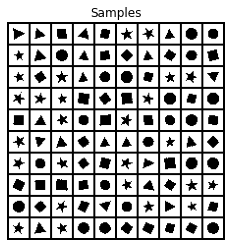

In [11]:
show_samples(shapes_train[:100])

In [12]:
shapes_train.shape

(10479, 20, 20, 1)

In [ ]:
train_dataloader_config = {
    'batch_size': 128,
    'shuffle': True,
}

test_dataloader_config = {
    'batch_size': 128,
    'shuffle': False,
}

learning_config = {
    'lr': 1E-3,
    'epochs': 70,
}

H, W, _ = shapes_train[0].shape

In [ ]:
H, W, _ = shapes_train[0].shape
model = RealNVP(1, H)
train_losses, test_losses, shapes_model = train_model(shapes_train, shapes_test, 
                                                      model, 'shapes', train_dataloader_config, 
                                                      test_dataloader_config, learning_config)

In [48]:
def show_train_plots(train_losses, test_losses, title):
    plt.figure()
    n_epochs = len(test_losses) - 1
    x_train = np.linspace(0, n_epochs, len(train_losses))
    x_test = np.arange(n_epochs + 1)

    plt.plot(x_train, train_losses, label='train loss')
    plt.plot(x_test, test_losses, label='test loss')
    plt.legend()
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('NLL')
    plt.ylim(0.4, 2)
    plt.show()

In [ ]:
show_train_plots(train_losses, test_losses, 'Shapes')

In [50]:
samples = shapes_model.sample(100).cpu()

In [ ]:
show_samples(samples, permute=False)

In [ ]:
# threshold depends on your model and (de)normalization
show_samples(samples, permute=False, binarize=0.7)

### Second dataset: MNIST (5 points)

Our reference loss is ~0.83 on test

In [ ]:
# For colab users: download file
! wget https://github.com/egiby/Generative-Models-MIPT/raw/hw1/module1-likelihood/mnist.pkl

In [52]:
mnist_train, mnist_test = load_data('./mnist.pkl')

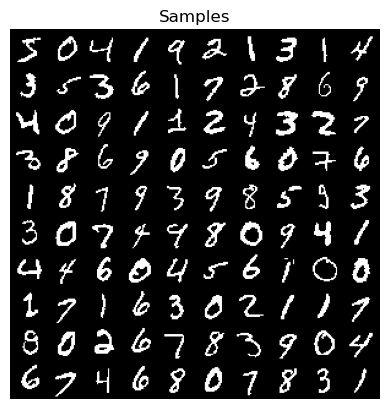

In [53]:
show_samples(mnist_train[:100])

In [ ]:
H, W, _ = mnist_train[0].shape
model = RealNVP(1, H)
train_losses, test_losses, mnist_model = train_model(mnist_train, mnist_test, model, 'mnist')

In [ ]:
show_train_plots(train_losses, test_losses, 'MNIST')

In [ ]:
samples = mnist_model.sample(100).cpu()
show_samples(samples, permute=False)

In [ ]:
# threshold depends on your model and (de)normalization
show_samples(samples, permute=False, binarize=0.8)